# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [1]:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator

import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils

importlib.reload(utils)

Using backend: pytorch


<module 'my_utils' from '/li_zhengdao/github/GenerativeGNN/my_utils.py'>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm


# here..
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


x_y_label_font = 20
x_y_legend_font = 20

plt.rc('font', family='Times New Roman')
fig_dpi = 220
fig_shape_squre = (6, 5)

def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh), dpi=100)
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list
    plt.show()

class MyColor(object):
    def __init__(self, cmap_name='tab10', skip_idx=5, backup_name='Set1', backup_color=3):
        self.color_set  = plt.get_cmap(cmap_name).colors
        self.backup_set = plt.get_cmap(backup_name).colors
        self.backup_color = backup_color
        self.skip_idx=skip_idx
        self.idx = 0
        self.color_len = len(self.color_set)
        
    def get_color(self, by_id=None):
        if by_id is not None:
            return self.color_set[by_id]
        
        if self.idx == self.color_len - 1:
            self.idx = 0
        if self.idx == self.skip_idx:
            self.idx += 1
            return self.backup_set[self.backup_color]
        color = self.color_set[self.idx]
        self.idx += 1
        return color
    

plot_color_gradients('Qualitative',
                     ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
                      'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',
                      'tab20c'])

<Figure size 640x338.2 with 13 Axes>

In [2]:
# Load all datasets:

import sys,os
sys.path.append(os.getcwd())


import my_utils
"""
    'REDDIT-BINARY': RedditBinary,
    'REDDIT-MULTI-5K': Reddit5K,
    'COLLAB': Collab,
    'IMDB-BINARY': IMDBBinary,
    'IMDB-MULTI': IMDBMulti,
    'NCI1': NCI1,
    'AIDS': AIDS,
    'ENZYMES': Enzymes,
    'PROTEINS': Proteins,
    'DD': DD,
    "MUTAG": Mutag,
    'CSL': CSL,
    'CIFAR10': CIFAR10,
    'MNIST': MNIST,
    'PPI': PPI,
    'hiv': HIV,
    'bace':BACE,
    'bbpb':BBPB,
    'ogbg_molhiv':OGBHIV,
    'ogbg_ppa':OGBPPA,
    'PTC': PTC,
    'QM9':QM9,
    'ogbg_moltox21': OGBTox21,
    'ogbg-molbbbp': OGBBBBP,
    'ogbg-molbace': OGBBACE,
    'syn_cc': SynCC,
    'syn_degree': SynDegree,
"""
from PrepareDatasets import DATASETS, DATASETS_used

import dataset_utils
print(DATASETS_used.keys())




dats = ['ogbg-molbace']

dats =['ogbg_moltox21']

name = 'ogbg_moltox21'
name = 'AIDS'
name = 'DD'

name = 'ogbg_ppa'
name = 'ENZYMES'
name = 'MNIST'
name = 'CIFAR10'
name = 'ogbg_molhiv'
dats = [name]

datasets_obj = {}
for k, v in DATASETS_used.items():
    print('dataset name:', k)
    if k not in dats:
        continue
    
    dat = v()
    datasets_obj[k] = dat

Using backend: pytorch


dict_keys(['REDDIT-BINARY', 'COLLAB', 'IMDB-BINARY', 'IMDB-MULTI', 'NCI1', 'AIDS', 'ENZYMES', 'PROTEINS', 'DD', 'MUTAG', 'CIFAR10', 'MNIST', 'ogbg_molhiv', 'ogbg_ppa', 'ogbg_moltox21', 'ogbg-molbace'])
dataset name: REDDIT-BINARY
dataset name: COLLAB
dataset name: IMDB-BINARY
dataset name: IMDB-MULTI
dataset name: NCI1
dataset name: AIDS
dataset name: ENZYMES
dataset name: PROTEINS
dataset name: DD
dataset name: MUTAG
dataset name: CIFAR10
dataset name: MNIST
dataset name: ogbg_molhiv
processed_dir:  DATA/ogbg-molhiv/processed
load dataset !
self.name: ogbg-molhiv
False
ogbg _dim_target: 2
!!!! _dim_target:  2
dataset len:  41127
dataset name: ogbg_ppa
dataset name: ogbg_moltox21
dataset name: ogbg-molbace


# visualize MoleculeNet

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

molecule = Chem.MolFromSmiles('c1ccccc1CC1CC1')

def plot_mol(mol_str, label=None):
    # Define your molecule

    # Generate 2D coordinates
    molecule = Chem.MolFromSmiles(mol_str)

    rdDepictor.Compute2DCoords(molecule)

    # Create a new drawing
    d = rdMolDraw2D.MolDraw2DSVG(400, 200)

    # Use this to color atoms
    atom_colors = {}
    for atom in molecule.GetAtoms():
        atom_colors[atom.GetIdx()] = (0.5,0.5,1)  # RGB color

    # Use this to color bonds
    bond_colors = {}
    for bond in molecule.GetBonds():
        bond_colors[bond.GetIdx()] = (1,0.5,0.5)  # RGB color

    # Draw the molecule with colors
    opts = d.drawOptions()
    d.DrawMolecule(molecule,highlightAtoms=range(molecule.GetNumAtoms()),
                highlightBonds=range(molecule.GetNumBonds()),
                highlightAtomColors=atom_colors,highlightBondColors=bond_colors)
    d.FinishDrawing()
    print(label)

    # Display the plot
    svg = SVG(d.GetDrawingText())
    display(svg)


In [4]:
from torch_geometric.datasets import QM9, MoleculeNet


dataset = MoleculeNet(root='DATA', name='HIV')

# Extract SMILES strings

i = 0
smiles_list = []
for data in dataset:
    # print(data.__dict__.keys())
    # print(data.__dict__['x'].shape, data.__dict__['smiles'])
    # if i > 5:
    #     break
    # i+=1
    smiles_list.append((data.smiles, data.y.item()))


CI


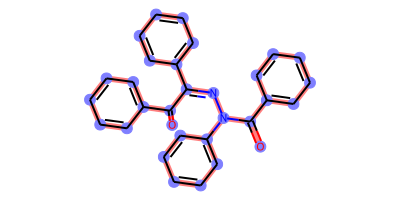

CI


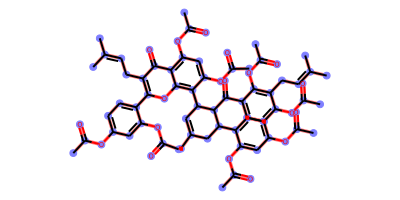

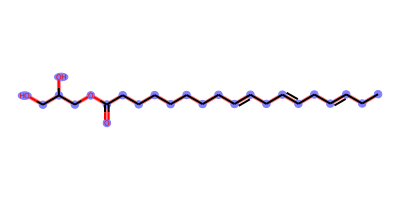

CI
CI


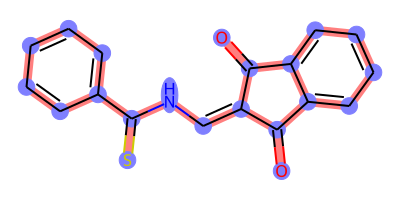

CI


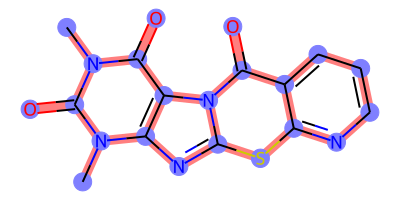

CI


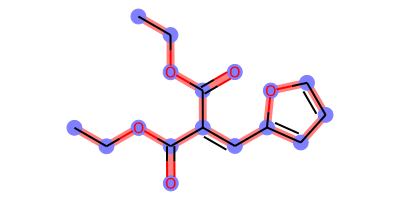

CI


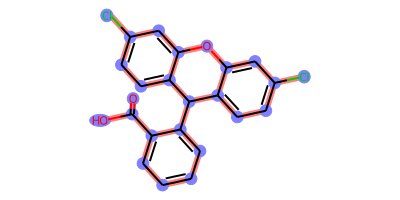

CI


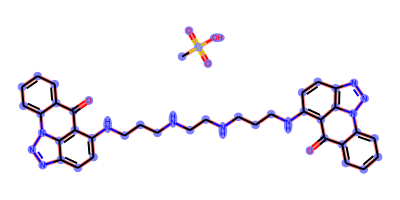

CI


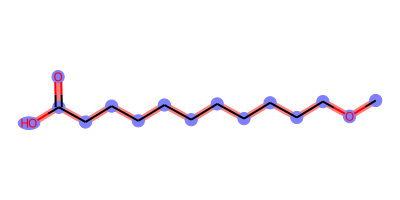

CI


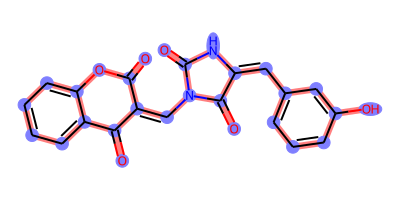

CI


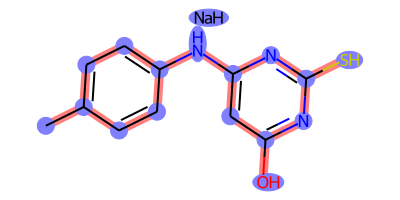

CI


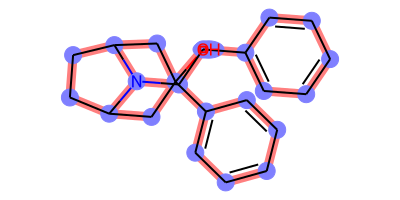

CI


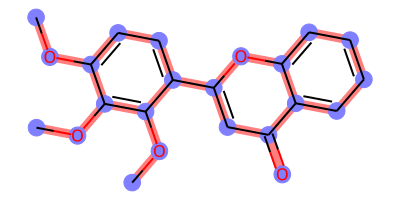

CI


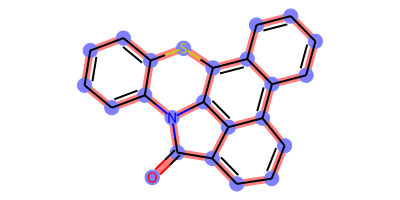

CI


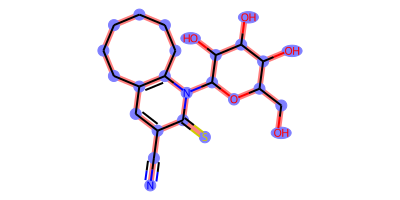

CI


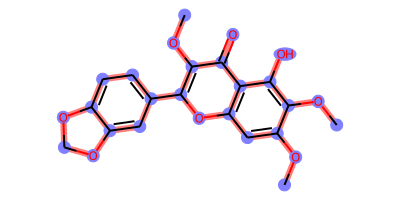

CI


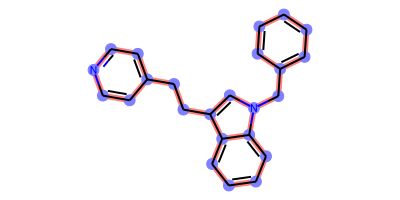

CI


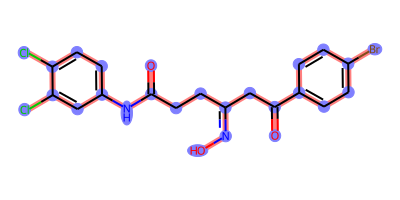

CI


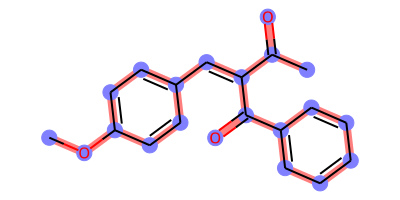

CI


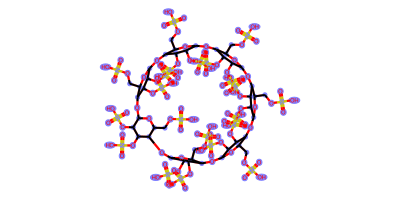

In [12]:
smiles_list_selected = smiles_list[20:40]
# smiles_list_selected = smiles_list
np.random.shuffle(smiles_list_selected)
for i, data in enumerate(smiles_list_selected):
    plot_mol(data[0], "CA/CM" if data[1] == 1 else "CI") 

CA/CM


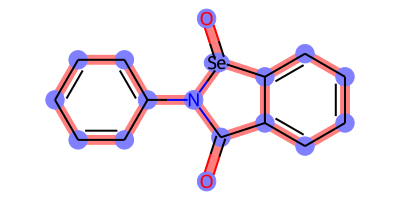

CA/CM


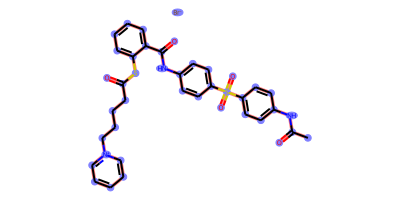

CA/CM


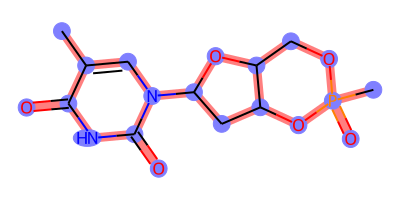

CA/CM


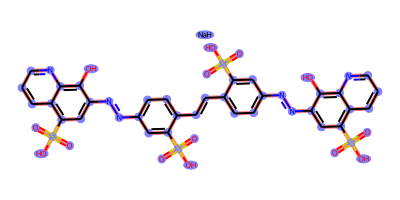

CA/CM


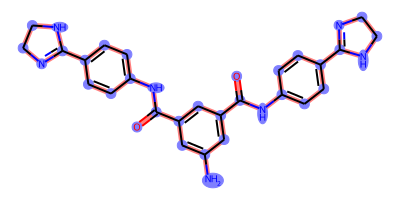

CA/CM


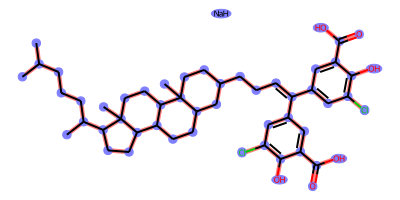

CA/CM


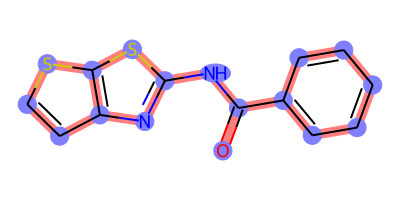

CA/CM


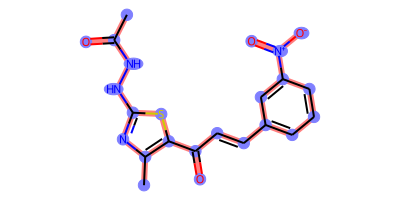

CA/CM


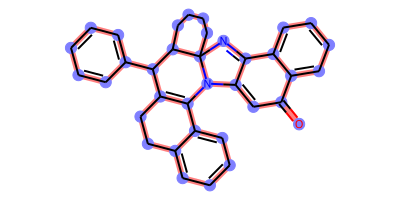

CA/CM


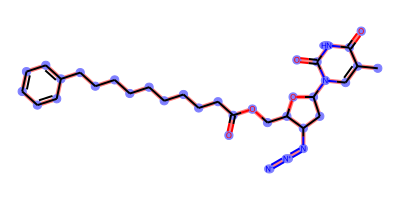

CA/CM


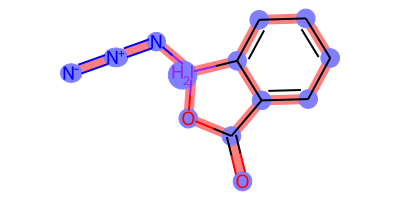

CA/CM


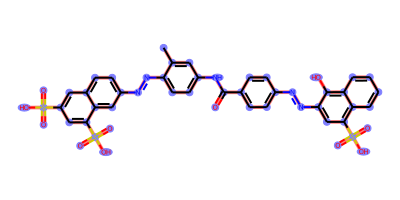

CA/CM


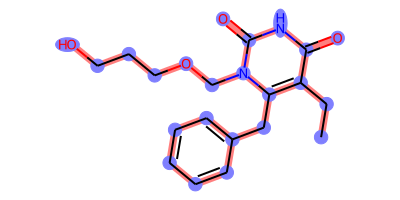

CA/CM


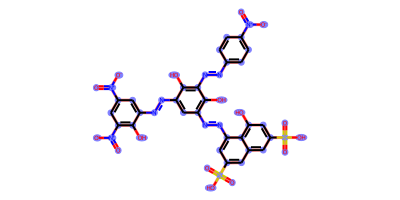

CA/CM


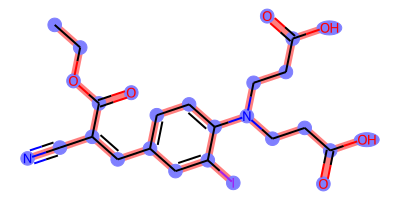

CA/CM


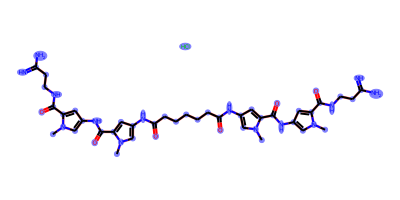

CA/CM


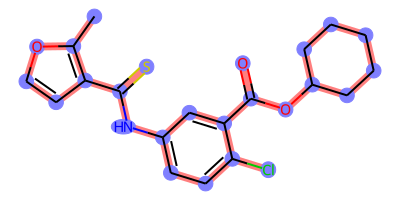

CA/CM


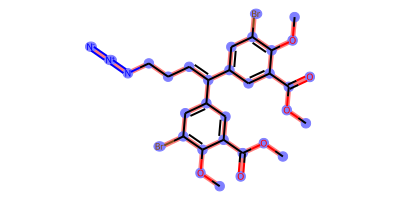

CA/CM


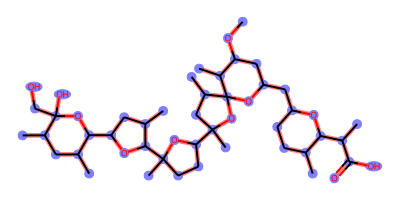

CA/CM


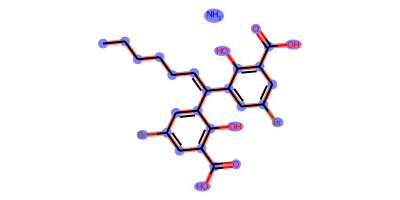

CA/CM


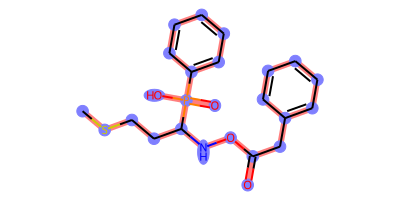

CA/CM


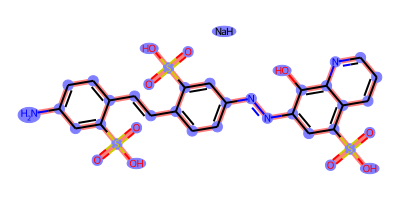

CA/CM


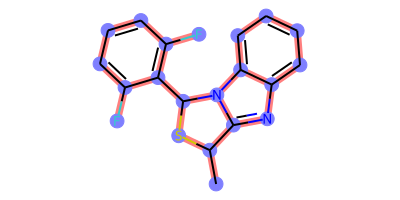

CA/CM


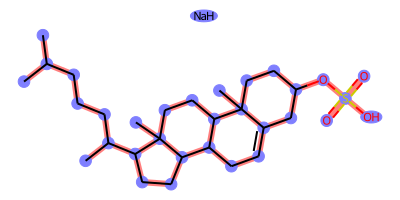

CA/CM


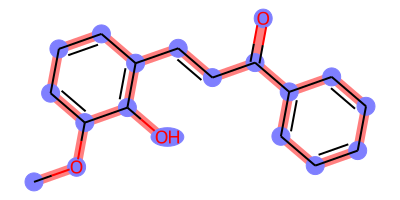

CA/CM


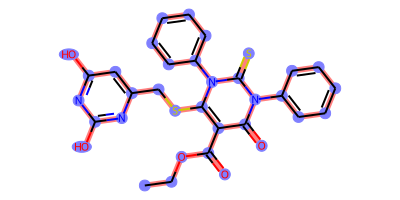

CA/CM


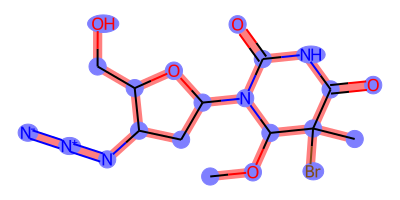

CA/CM


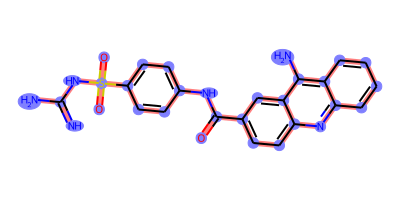

CA/CM


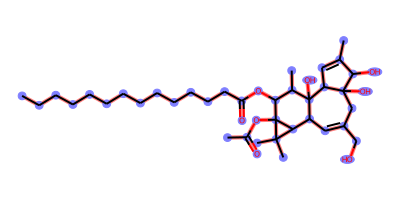

CA/CM


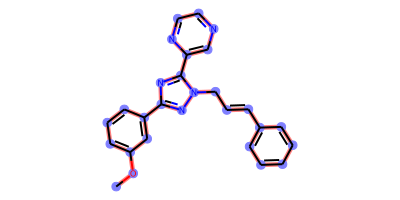

CA/CM


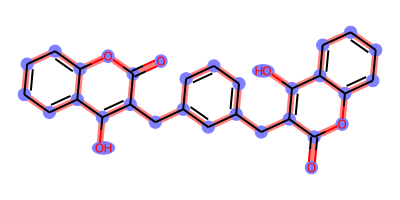

CA/CM


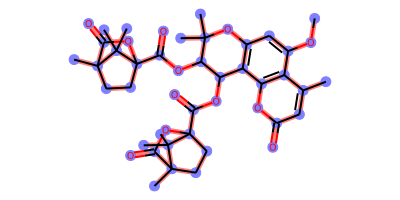

CA/CM


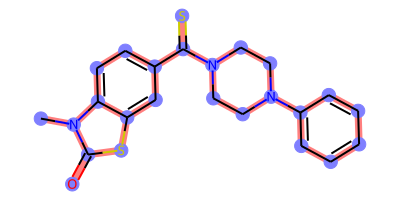

CA/CM


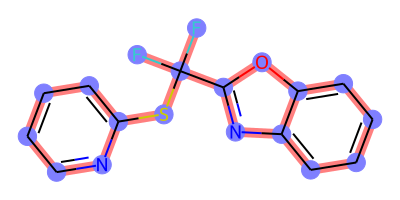

CA/CM


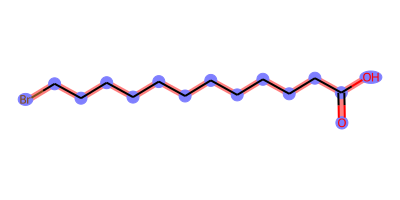

CA/CM


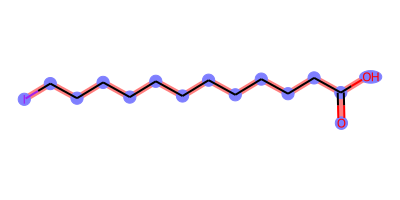

CA/CM


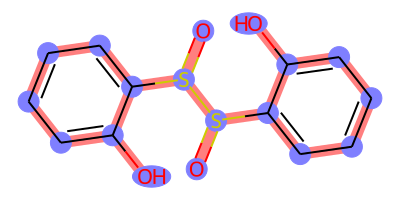

CA/CM


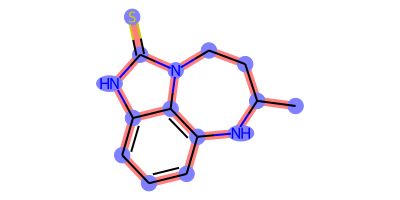

CA/CM


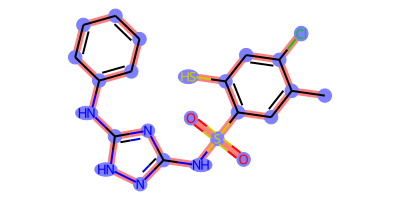

CA/CM


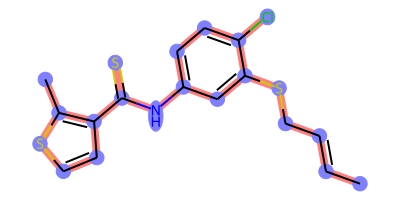

CA/CM


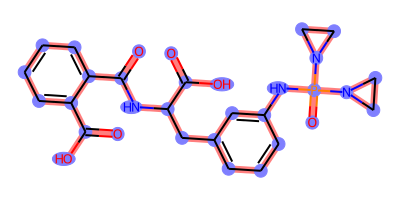

1635


In [11]:
smiles_list_selected = smiles_list
# smiles_list_selected = smiles_list
np.random.shuffle(smiles_list_selected)
count  = 40
for i, data in enumerate(smiles_list_selected):
    if data[1] == 0:
        continue
    plot_mol(data[0], "CA/CM" if data[1] == 1 else "CI") 
    if count == 0:
        print(i)
        break
    count -= 1
    
    